In [2]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
from Bio import SeqIO
from tqdm.notebook import tqdm

# Set paths
generated_fasta = "../generated_samples/e3/samples_ctx<|pf00257|>1_k15_t1.0.fa"
train_fasta = "../downloads/PF00257.fasta"

# Create output directory for results
os.makedirs("evaluation_results", exist_ok=True)

# Function to read FASTA sequences into a dictionary
def read_fasta(fasta_file):
    sequences = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

# Load the generated sequences
generated_sequences = read_fasta(generated_fasta)
print(f"Loaded {len(generated_sequences)} generated sequences")

# Filter out empty sequences
valid_sequences = {k: v for k, v in generated_sequences.items() if v.strip()}
print(f"Valid sequences: {len(valid_sequences)} ({len(valid_sequences)/len(generated_sequences)*100:.1f}%)")

# Display a few examples
for i, (seq_id, seq) in enumerate(list(valid_sequences.items())[:5]):
    print(f"Sequence {i+1} ({seq_id}): {seq[:50]}{'...' if len(seq) > 50 else ''}")

Loaded 128 generated sequences
Valid sequences: 82 (64.1%)
Sequence 1 (seq_0): MEAGSISSGAEQQDRGMFEFLGKKDEEKPQDKHQGMIEKIKEKLPGHHNN...
Sequence 2 (seq_2): MAASLSAQHGVSSSPAAYTASTAVPQTGTSTYTGGTGVTNSAATEAADKK...
Sequence 3 (seq_4): MHKGAKNYTDEYGNPVPHTDEYGEPVHHTDEYGNPIHHTDGTGVQPTGTV...
Sequence 4 (seq_5): MGEHQGQYGSDSRVEEYGAHGNELLGGHKKVGEEYGSESGYEDGYENEQH...
Sequence 5 (seq_7): MGTSVHPAEIVKVASDPFGNPIHHKMAPADAHGHGHGHPTTAGGYGGTST...


In [3]:
# Save valid sequences to a new FASTA file for HMMER analysis
filtered_fasta = "evaluation_results/filtered_sequences.fa"
with open(filtered_fasta, "w") as f:
    for seq_id, seq in valid_sequences.items():
        f.write(f">{seq_id}\n{seq}\n")

# Download Pfam HMM if not already present
pfam_dir = "pfam_profiles"
pfam_hmm = os.path.join(pfam_dir, "PF00257.hmm")

if not os.path.exists(pfam_hmm):
    os.makedirs(pfam_dir, exist_ok=True)
    # Try to download from Pfam
    try:
        cmd = f"wget http://pfam.xfam.org/family/PF00257/hmm -O {pfam_hmm}"
        subprocess.run(cmd, shell=True, check=True)
        # Press the HMM file
        subprocess.run(f"hmmpress {pfam_hmm}", shell=True, check=True)
    except:
        print("Could not download Pfam HMM. Please install HMMER and download the profile manually.")

# Run HMMER if available
hmmer_output = "evaluation_results/hmmer_results.txt"
try:
    cmd = f"hmmsearch --tblout {hmmer_output} {pfam_hmm} {filtered_fasta}"
    subprocess.run(cmd, shell=True, check=True)
    
    # Parse HMMER output
    matches = set()
    with open(hmmer_output, "r") as f:
        for line in f:
            if line.startswith("#"):
                continue
            parts = line.split()
            if len(parts) > 0:
                matches.add(parts[0])
    
    # Calculate statistics
    match_count = len(matches)
    total_count = len(valid_sequences)
    match_percentage = (match_count / total_count) * 100
    
    print(f"HMMER analysis results:")
    print(f"Total sequences analyzed: {total_count}")
    print(f"Sequences matching PF00257 family: {match_count}")
    print(f"Percentage of sequences in family: {match_percentage:.2f}%")
    
    # Visualize results
    plt.figure(figsize=(8, 6))
    plt.pie([match_count, total_count - match_count], 
            labels=['Matches', 'Non-matches'],
            autopct='%1.1f%%',
            colors=['#5cb85c', '#d9534f'],
            explode=(0.1, 0))
    plt.title('HMMER Analysis: Generated Sequences Matching PF00257 Family')
    plt.savefig("evaluation_results/hmmer_results.png")
    plt.show()
    
except Exception as e:
    print(f"Error running HMMER: {e}")
    print("Skipping HMMER analysis. Please install HMMER to perform this evaluation.")

Could not download Pfam HMM. Please install HMMER and download the profile manually.
Error running HMMER: Command 'hmmsearch --tblout evaluation_results/hmmer_results.txt pfam_profiles/PF00257.hmm evaluation_results/filtered_sequences.fa' returned non-zero exit status 127.
Skipping HMMER analysis. Please install HMMER to perform this evaluation.


/bin/sh: wget: command not found
/bin/sh: hmmsearch: command not found


Loaded 3148 training sequences
Calculating sequence identity to training data...
Using a sample of 1000 training sequences for faster computation


  0%|          | 0/82 [00:00<?, ?it/s]


Sequence Identity Analysis:
Average maximum sequence identity: 22.24%
Median maximum sequence identity: 21.88%
Sequences with < 40% identity: 82 (100.00%)
Sequences with < 50% identity: 82 (100.00%)
Sequences with < 60% identity: 82 (100.00%)
Sequences with < 70% identity: 82 (100.00%)
Sequences with < 80% identity: 82 (100.00%)
Sequences with < 90% identity: 82 (100.00%)
Sequences with < 95% identity: 82 (100.00%)


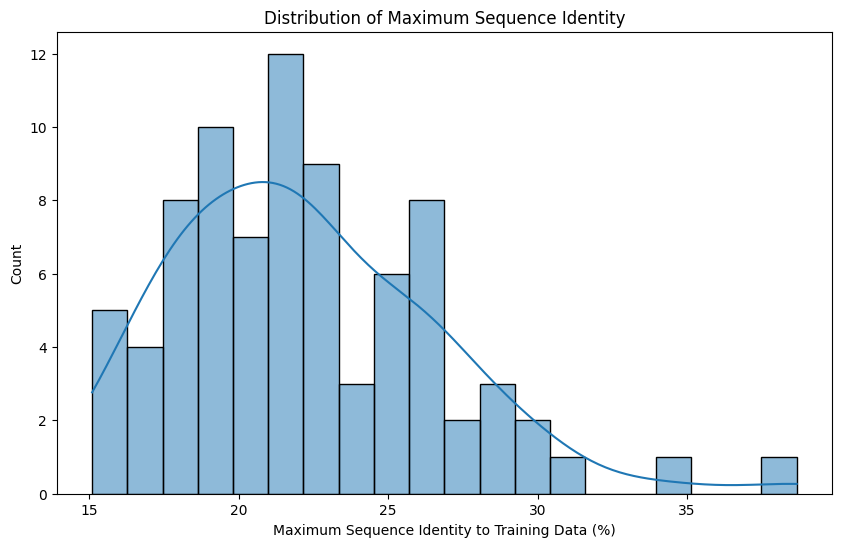

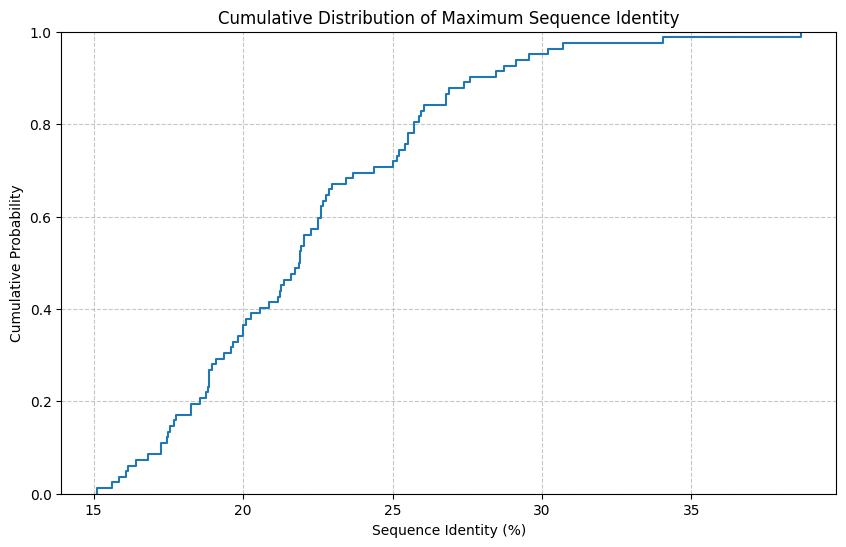

In [4]:
# Continue with sequence similarity analysis only
# Load the training sequences
train_sequences = read_fasta(train_fasta)
print(f"Loaded {len(train_sequences)} training sequences")

# Function to calculate sequence identity between two sequences
def sequence_identity(seq1, seq2):
    """Calculate simple sequence identity (percentage of matching characters)"""
    if not seq1 or not seq2:
        return 0
    
    # Align from beginning (this is a simple approach)
    # For more accurate alignment, you'd want to use a proper alignment algorithm
    min_len = min(len(seq1), len(seq2))
    matches = sum(a == b for a, b in zip(seq1[:min_len], seq2[:min_len]))
    
    return (matches / min_len) * 100

# For each generated sequence, find max identity to any training sequence
print("Calculating sequence identity to training data...")
max_identities = []

# Use a subsample of training sequences if there are too many (for speed)
if len(train_sequences) > 1000:
    train_sample = dict(list(train_sequences.items())[:1000])
    print(f"Using a sample of 1000 training sequences for faster computation")
else:
    train_sample = train_sequences

for gen_id, gen_seq in tqdm(valid_sequences.items()):
    max_identity = 0
    for train_id, train_seq in train_sample.items():
        identity = sequence_identity(gen_seq, train_seq)
        max_identity = max(max_identity, identity)
    max_identities.append((gen_id, max_identity))

# Convert to DataFrame for analysis
identity_df = pd.DataFrame(max_identities, columns=['sequence_id', 'max_identity'])

# Calculate statistics
print("\nSequence Identity Analysis:")
print(f"Average maximum sequence identity: {identity_df['max_identity'].mean():.2f}%")
print(f"Median maximum sequence identity: {identity_df['max_identity'].median():.2f}%")

# Calculate distribution statistics
thresholds = [40, 50, 60, 70, 80, 90, 95]
for threshold in thresholds:
    below = (identity_df['max_identity'] < threshold).sum()
    percentage = (below / len(identity_df)) * 100
    print(f"Sequences with < {threshold}% identity: {below} ({percentage:.2f}%)")

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(identity_df['max_identity'], bins=20, kde=True)
plt.xlabel("Maximum Sequence Identity to Training Data (%)")
plt.ylabel("Count")
plt.title("Distribution of Maximum Sequence Identity")
plt.savefig("evaluation_results/identity_histogram.png")
plt.show()

# Plot cumulative distribution (like Figure 1 in the paper)
plt.figure(figsize=(10, 6))
sns.ecdfplot(identity_df['max_identity'])
plt.xlabel("Sequence Identity (%)")
plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of Maximum Sequence Identity")
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig("evaluation_results/identity_cumulative.png")
plt.show()